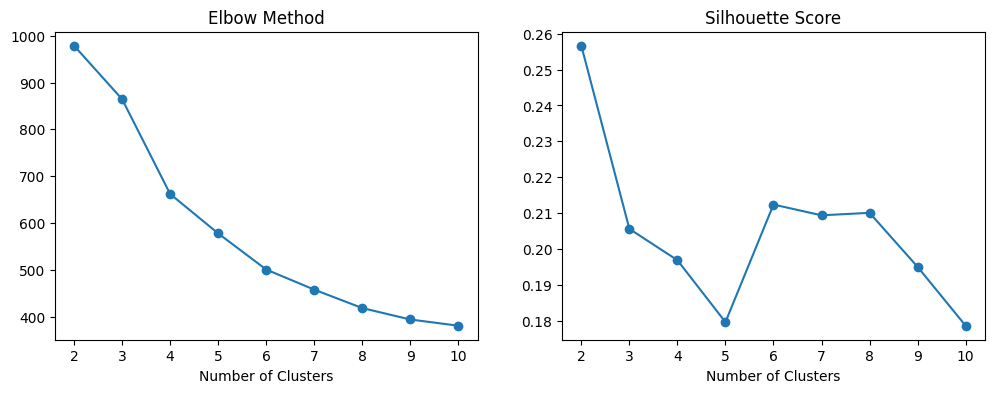

Davies-Bouldin Index: 1.261
Silhouette Score: 0.197


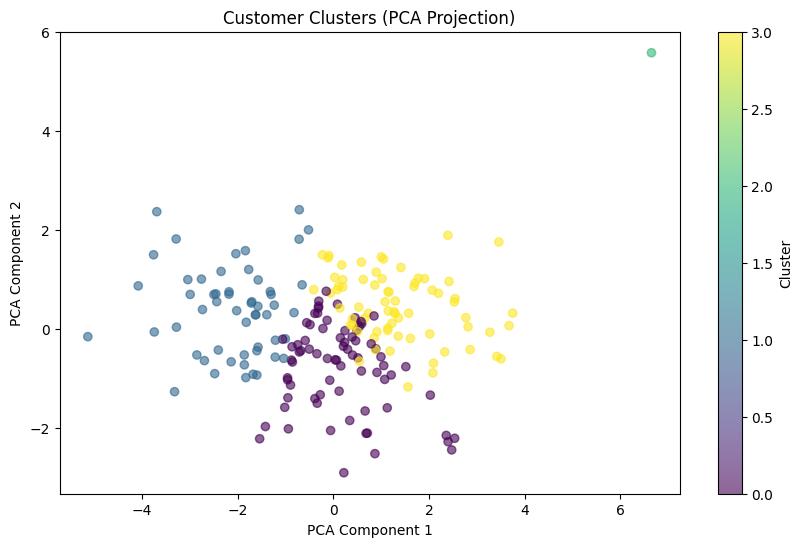

In [1]:
# FirstName_LastName_Clustering.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Load datasets
customers = pd.read_csv('Customers.csv', parse_dates=['SignupDate'])
transactions = pd.read_csv('Transactions.csv', parse_dates=['TransactionDate'])

# Merge Customers and Transactions (left join to retain all customers)
merged = pd.merge(customers, transactions, on='CustomerID', how='left')

# Feature Engineering
# 1. Transaction Features
transaction_agg = merged.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count'],  # TotalSpend, AvgOrderValue, TransactionCount
    'Quantity': 'sum',                       # TotalQuantity
    'TransactionDate': 'max'                 # LastTransactionDate
}).reset_index()

transaction_agg.columns = [
    'CustomerID', 'TotalSpend', 'AvgOrderValue', 'TransactionCount', 
    'TotalQuantity', 'LastTransactionDate'
]

# 2. Profile Features (Region, Tenure)
# Merge transaction aggregation with customer data
customer_features = pd.merge(
    customers[['CustomerID', 'Region', 'SignupDate']], 
    transaction_agg, 
    on='CustomerID', 
    how='left'
)

# Handle missing transaction data (customers with no transactions)
customer_features.fillna({
    'TotalSpend': 0, 'AvgOrderValue': 0, 'TransactionCount': 0, 
    'TotalQuantity': 0, 'LastTransactionDate': pd.NaT
}, inplace=True)

# Compute Recency and Tenure
latest_date = merged['TransactionDate'].max()  # Most recent transaction in the dataset

# Recency: Days since last transaction (or 9999 if no transactions)
customer_features['Recency'] = (
    (latest_date - customer_features['LastTransactionDate']).dt.days
).fillna(9999)

# Tenure: Days from signup to last transaction (or to latest_date if no transactions)
customer_features['Tenure'] = np.where(
    customer_features['LastTransactionDate'].isna(),
    (latest_date - customer_features['SignupDate']).dt.days,
    (customer_features['LastTransactionDate'] - customer_features['SignupDate']).dt.days
)

# Final Features (drop unnecessary columns)
final_features = customer_features[[
    'TotalSpend', 'AvgOrderValue', 'TransactionCount', 
    'TotalQuantity', 'Recency', 'Tenure', 'Region'
]]

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), [
        'TotalSpend', 'AvgOrderValue', 'TransactionCount', 
        'TotalQuantity', 'Recency', 'Tenure'
    ]),
    ('cat', OneHotEncoder(), ['Region'])
])

processed_data = preprocessor.fit_transform(final_features)

# Determine Optimal Clusters (Elbow Method + Silhouette Score)
inertia = []
silhouette = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(processed_data)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(processed_data, labels))

# Plot Elbow and Silhouette
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.show()

# Final Clustering (k=4 chosen based on plots)
final_model = KMeans(n_clusters=4, random_state=42)
clusters = final_model.fit_predict(processed_data)

# Metrics
db_index = davies_bouldin_score(processed_data, clusters)
sil_score = silhouette_score(processed_data, clusters)

print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Silhouette Score: {sil_score:.3f}")

# Visualize Clusters (PCA for 2D projection)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(processed_data.toarray() if hasattr(processed_data, 'toarray') else processed_data)

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('Customer Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()